# Когортный анализ: удержание клиентов

In [7]:
import pandas as pd
import numpy as np

In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy

In [9]:
%matplotlib inline

In [10]:
dog = pd.read_csv('test_sobaka.csv')

In [11]:
dog.head()

,Datetime,Client_id,Price
0,2018-01-31 22:30:00,1,500
1,2018-01-31 22:00:00,2,500
2,2018-01-31 21:00:00,3,500
3,2018-01-31 21:00:00,4,500
4,2018-01-31 20:30:00,5,500


1. Создадим столбец месяца заказа Order_Period.
Будем анализировать поведение наших пользователей за месяц, поэтому нам пока не нужны детальные данные Datetime.

In [12]:
dog['Datetime'] = pd.to_datetime(dog.Datetime, format='%Y-%m-%d %H:%M:%S')
dog['Order_Period'] = dog.Datetime.apply(lambda x: x.strftime('%Y-%m'))
dog.head()

,Datetime,Client_id,Price,Order_Period
0,2018-01-31 22:30:00,1,500,2018-01
1,2018-01-31 22:00:00,2,500,2018-01
2,2018-01-31 21:00:00,3,500,2018-01
3,2018-01-31 21:00:00,4,500,2018-01
4,2018-01-31 20:30:00,5,500,2018-01


2. Определим когорты пользователей (исходя из даты их первого заказа).
Создадим новый столбец с именем Cohort_Group, в котором указываются год и месяц, когда была совершена первая покупка пользователя.

In [13]:
dog.set_index('Client_id', inplace=True)

dog['Cohort_Group'] = dog.groupby(level=0)['Datetime'].min().apply(lambda x: x.strftime('%Y-%m'))
dog.reset_index(inplace=True)
dog.head()

,Client_id,Datetime,Price,Order_Period,Cohort_Group
0,1,2018-01-31 22:30:00,500,2018-01,2017-12
1,2,2018-01-31 22:00:00,500,2018-01,2017-12
2,3,2018-01-31 21:00:00,500,2018-01,2016-11
3,4,2018-01-31 21:00:00,500,2018-01,2017-12
4,5,2018-01-31 20:30:00,500,2018-01,2018-01


3. Сводные данные по Cohort_Group и Order_Period.
Поскольку мы рассматриваем ежемесячные когорты, нам необходимо агрегировать пользователей, заказы и суммы, потраченные когортой (Cohort_Group) в течение месяца (Order_Period).

In [14]:
grouped = dog.groupby(['Cohort_Group','Order_Period'])

# считаем уникальных пользователей и уникальные заказы в каждой группе и периоде
cohorts = grouped.agg({'Client_id': pd.Series.nunique,
                       'Datetime': pd.Series.nunique,
                       'Price': np.sum})


In [15]:
# переименуем колонки
cohorts.rename(columns={'Client_id': 'Total_Users',
                        'Datetime': 'Total_Orders',
                        'Price': 'Total_Charges'}, inplace=True)
cohorts.head()

Total_Users  Total_Orders  Total_Charges
Cohort_Group Order_Period                                          
2016-09      2016-09                18           131          77000
             2016-10                 9           126          73800
             2016-11                10           130          79100
             2016-12                11           140          82900
             2017-01                 8           111          65000

4. Проиндексировать месяцы для каждой когорты (CohortPeriod for Cohort_Group).
Чтобы проанализировать поведение когорт в месяцы после первой покупки, нужно проиндексировать эти месяцы. Так, CohortPeriod = 1 будет первым месяцем когорты, CohortPeriod = 2 - вторым и так далее. Это позволит сравнивать когорты на разных этапах их жизни.

In [16]:
def cohort_period(df):
    df['CohortPeriod'] = np.arange(len(df)) + 1
    return df

cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts

Total_Users  Total_Orders  Total_Charges  \
Cohort_Group Order_Period                                             
2016-09      2016-09                18           131          77000   
             2016-10                 9           126          73800   
             2016-11                10           130          79100   
             2016-12                11           140          82900   
             2017-01                 8           111          65000   
             2017-02                10           110          66900   
             2017-03                10           132          79800   
             2017-04                 9           148          85000   
             2017-05                 8           117          71500   
             2017-06                 9           128          75000   
             2017-07                10            74          47000   
             2017-08                 7           102          66000   
             2017-09                 6           113          69500   
             2017-10                 8           160          96000   
             2017-11                 6           108          71000   
             2017-12                 5            82          54000   
             2018-01                 4            73          47000   
             2018-02                 4            53          36500   
             2018-03                 2            19           9500   
2016-10      2016-10                12            59          31600   
             2016-11                 9            68          34500   
             2016-12                 6            28          13900   
             2017-01                 5            25          12000   
             2017-02                 6            28          13400   
             2017-03                 5            40          19300   
             2017-04                 6            41          19600   
             2017-05                 6            26          13600   
             2017-06                 4            18           8700   
             2017-07                 2            10           4600   
             2017-08                 2            29          14500   
...                                ...           ...            ...   
2017-08      2018-02                 5            44          26000   
             2018-03                 5            26          16500   
2017-09      2017-09                31           163          93800   
             2017-10                16           163          92700   
             2017-11                13           112          67500   
             2017-12                11           134          74700   
             2018-01                10            84          50700   
             2018-02                12           106          63600   
             2018-03                 9            45          26600   
2017-10      2017-10                35           154          79700   
             2017-11                17           173         100900   
             2017-12                17           131          70400   
             2018-01                10            99          53900   
             2018-02                10            35          18800   
             2018-03                 5            12           5900   
2017-11      2017-11                38           187         103700   
             2017-12                21           184         100800   
             2018-01                18           161          85900   
             2018-02                15           151          80300   
             2018-03                10            33          16800   
2017-12      2017-12                63           289         195300   
             2018-01                36           236         133500   
             2018-02                23           163         105300   
             2018-03                17            5

5. Проверка.
Протестируем точки данных из исходного датасета с соответствующими значениями в датасете новых когорт.

In [17]:
x = dog[(dog.Cohort_Group == '2016-09') & (dog.Order_Period == '2016-09')]
y = cohorts.loc[('2016-09', '2016-09')]

assert(x['Client_id'].nunique() == y['Total_Users'])
assert(x['Price'].sum() == y['Total_Charges'])
assert(x['Datetime'].nunique() == y['Total_Orders'])

In [18]:
x = dog[(dog.Cohort_Group == '2016-09') & (dog.Order_Period == '2017-02')]
y = cohorts.loc[('2016-09', '2017-02')]

assert(x['Client_id'].nunique() == y['Total_Users'])
assert(x['Price'].sum() == y['Total_Charges'])
assert(x['Datetime'].nunique() == y['Total_Orders'])

In [19]:
x = dog[(dog.Cohort_Group == '2017-08') & (dog.Order_Period == '2018-03')]
y = cohorts.loc[('2017-08', '2018-03')]

assert(x['Client_id'].nunique() == y['Total_Users'])
assert(x['Price'].sum() == y['Total_Charges'])
assert(x['Datetime'].nunique() == y['Total_Orders'])

6. Формирум таблицу удержания пользователей
Мы хотим посмотреть на процентное изменение каждой группы Cohort_Group с течением времени, а не на абсолютное изменение.

In [20]:
# reindex the DataFrame
cohorts.reset_index(inplace=True)
cohorts.set_index(['Cohort_Group', 'CohortPeriod'], inplace=True)

In [21]:
# создадим список с размерами когорт
cohort_group_size = cohorts['Total_Users'].groupby(level=0).first()
cohort_group_size.head()

Cohort_Group
2016-09    18
2016-10    12
2016-11    15
2016-12    19
2017-01    10
Name: Total_Users, dtype: int64

Теперь нам нужно разделить значения Total_Users в когортах на cohort_group_size. Поскольку операции в датасете выполняются на основе индексов объектов, мы будем использовать unstack для датасета с когортами для создания матрицы, в которой каждый столбец представляет Cohort_Group, а каждая строка - CohortPeriod, соответствующий этой группе.

In [22]:
cohorts['Total_Users'].unstack(0).head()

Cohort_Group,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03
CohortPeriod,,,,,,,,,,,,,,,,,,,
1,18.0,12.0,15.0,19.0,10.0,8.0,17.0,18.0,26.0,32.0,38.0,30.0,31.0,35.0,38.0,63.0,49.0,76.0,36.0
2,9.0,9.0,7.0,10.0,4.0,6.0,8.0,8.0,6.0,17.0,14.0,14.0,16.0,17.0,21.0,36.0,25.0,26.0,NaN
3,10.0,6.0,3.0,5.0,1.0,6.0,6.0,5.0,6.0,11.0,12.0,10.0,13.0,17.0,18.0,23.0,13.0,NaN,NaN
4,11.0,5.0,7.0,4.0,1.0,6.0,8.0,5.0,7.0,8.0,7.0,10.0,11.0,10.0,15.0,17.0,NaN,NaN,NaN
5,8.0,6.0,9.0,4.0,1.0,5.0,4.0,3.0,7.0,9.0,8.0,9.0,10.0,10.0,10.0,NaN,NaN,NaN,NaN


Получившийся датасет, user_retention, содержит долю пользователей из когорты, совершивших покупки в течение заданного периода. Например, 75% пользователей из когорты 2016 совершили повторную покупку в 2-м месяце (это будет ноябрь 2016).

In [23]:
user_retention = cohorts['Total_Users'].unstack(0).divide(cohort_group_size, axis=1)
user_retention.head(10)

Cohort_Group,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03
CohortPeriod,,,,,,,,,,,,,,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.0,1.000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
2,0.500000,0.750000,0.466667,0.526316,0.4,0.750,0.470588,0.444444,0.230769,0.53125,0.368421,0.466667,0.516129,0.485714,0.552632,0.571429,0.510204,0.342105,NaN
3,0.555556,0.500000,0.200000,0.263158,0.1,0.750,0.352941,0.277778,0.230769,0.34375,0.315789,0.333333,0.419355,0.485714,0.473684,0.365079,0.265306,NaN,NaN
4,0.611111,0.416667,0.466667,0.210526,0.1,0.750,0.470588,0.277778,0.269231,0.25000,0.184211,0.333333,0.354839,0.285714,0.394737,0.269841,NaN,NaN,NaN
5,0.444444,0.500000,0.600000,0.210526,0.1,0.625,0.235294,0.166667,0.269231,0.28125,0.210526,0.300000,0.322581,0.285714,0.263158,NaN,NaN,NaN,NaN
6,0.555556,0.416667,0.333333,0.210526,0.2,0.500,0.294118,0.222222,0.269231,0.21875,0.210526,0.200000,0.387097,0.142857,NaN,NaN,NaN,NaN,NaN
7,0.555556,0.500000,0.400000,0.105263,0.1,0.500,0.235294,0.277778,0.230769,0.18750,0.184211,0.166667,0.290323,NaN,NaN,NaN,NaN,NaN,NaN
8,0.500000,0.500000,0.400000,0.105263,0.1,0.625,0.294118,0.277778,0.269231,0.15625,0.210526,0.166667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.444444,0.333333,0.266667,0.052632,0.1,0.625,0.235294,0.166667,0.153846,0.09375,0.210526,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


7. Визуализация.
Построим график удержания пользователей. С большим числокогорт выходит малоинтерпретируемо.

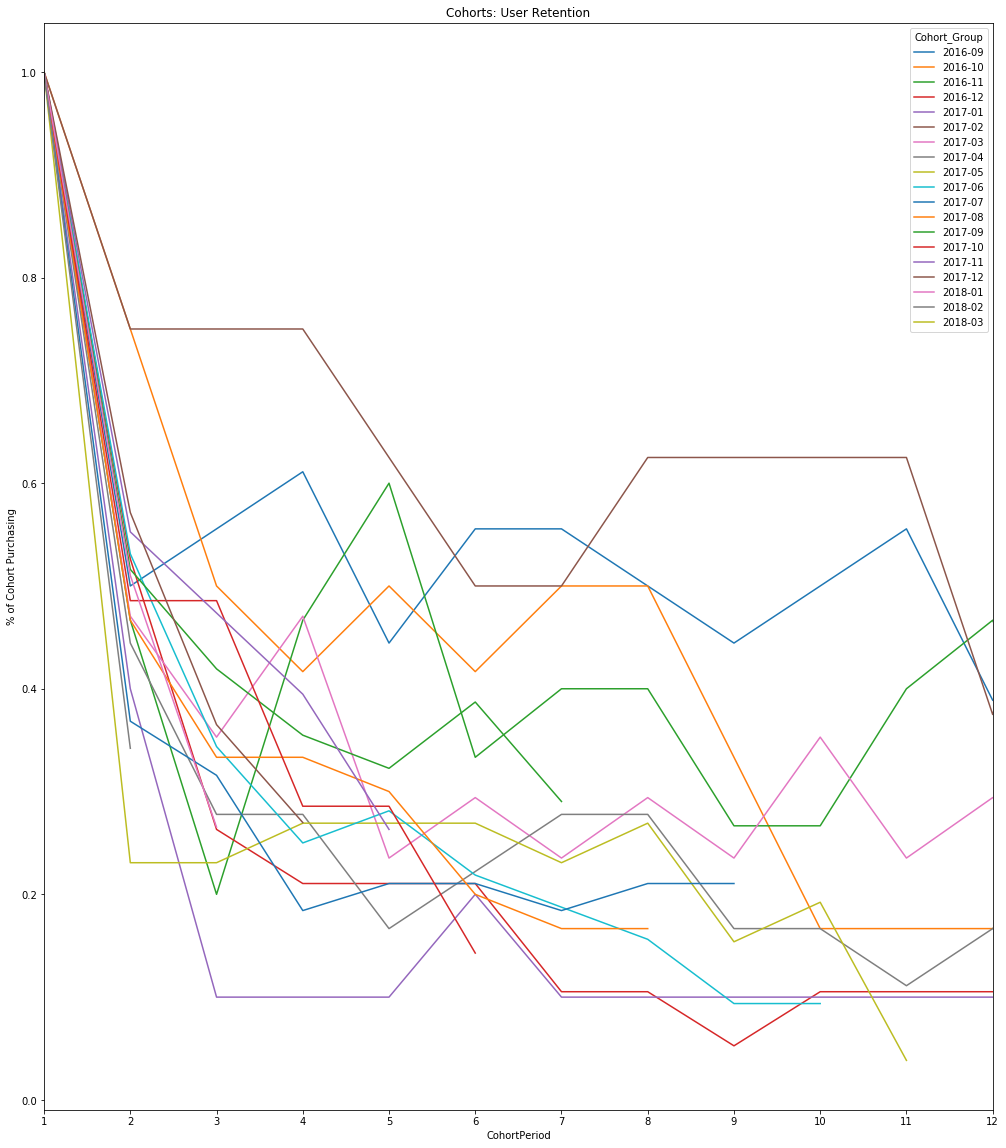

In [24]:
user_retention.plot(figsize=(17,20))
plt.title('Cohorts: User Retention')
plt.xticks(np.arange(1, 12.1, 1))
plt.xlim(1, 12)
plt.ylabel('% of Cohort Purchasing');

Тогда построим тепловую матрицу. Чем светлее ячейка, тем выше значение.

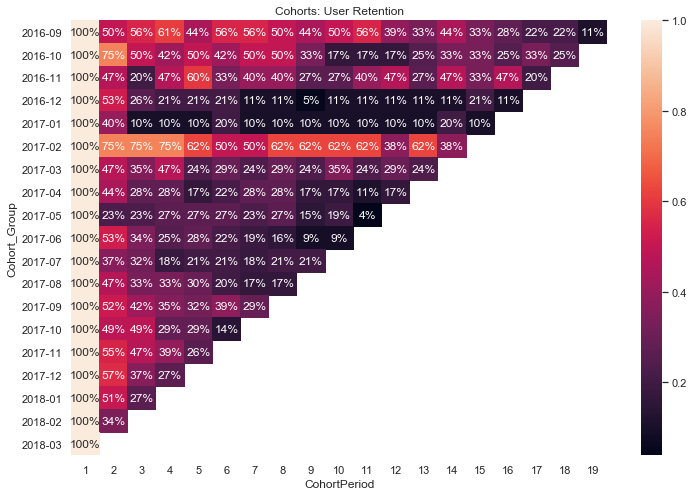

In [25]:
import seaborn as sns
sns.set(style='white')

plt.figure(figsize=(12, 8))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.0%');

Можем заметить, что первая когорта продолжает сохранять лояльность: половина пользователей стабильно совершает покупки в течение 11 месяцев. 

Провальным оказалось удержание пользователей, появившихся в декабре 2016 - январе 2017. Услугами воспользовались перед Новым годом, но причина падения не в этом: на следующий месяц retention такой же высокий, как и во всех других случаях. Пользователей не поддерживали и не привлекали в следующие месяцы, возможно, они столкнулись с изменением ценовой политики.

In [26]:
dog.mean()

Client_id    147.156204
Price        488.841704
dtype: float64

In [34]:
dog[dog['Cohort_Group'] == '2016-12'].describe()

,Client_id,Price
count,448.000000,448.000000
mean,226.633929,497.991071
std,176.835759,14.046261
min,8.000000,400.000000
25%,8.000000,500.000000
50%,283.500000,500.000000
75%,379.000000,500.000000
max,445.000000,500.000000


In [30]:
dog[dog['Cohort_Group'] == '2016-11'].describe()

,Client_id,Price
count,1851.000000,1851.000000
mean,90.461372,475.850891
std,109.298733,42.810297
min,3.000000,400.000000
25%,3.000000,500.000000
50%,7.000000,500.000000
75%,200.000000,500.000000
max,451.000000,500.000000


Нет, ценовая политика тут не при чем: средняя цена одинакова, распределение цены поквантилям тоже. Скорее всего, дело в рекламных акциях. Отдел маркетинга осознал свою ошибку, и появилась еще одна лояльная когорта - пользователи февраля 2017, более половины которых совершали повторные покупки в течение года.